In [2]:
import pandas as pd
import numpy as np
import sklearn
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
from mpl_toolkits.basemap import Basemap
sns.set_style('darkgrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# View all columns on the screen
pd.set_option('max_columns', 100)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',1000)

In [4]:
query_string1 = '''
                select * from merged order by pickup_datetime asc
'''

In [5]:
# Connect to the existing fleetriskdb
con = sqlite3.connect('./DB/nyctaximergeddb.sqlite')
# Confirm data is being returned from this query
df = pd.read_sql_query(query_string1, con)
# Verify that result of SQL query is stored in the dataframe
df = df.drop('index', axis=1)
df.tail()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
14064063,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,1,2013-04-30 23:59:57,2013-05-01 00:03:37,1,219,1.0,-73.981850,40.783993,-73.991020,40.770947,CSH,5.5,0.5,0.5,0.00,0.0,6.50
14064064,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,1,2013-04-30 23:59:58,2013-05-01 00:16:44,1,1006,4.2,-73.976997,40.761559,-74.003853,40.742271,CRD,14.5,0.5,0.5,2.00,0.0,17.50
14064065,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,1,2013-04-30 23:59:58,2013-05-01 00:02:52,2,173,0.6,-73.979881,40.776081,-73.982071,40.768272,CRD,4.0,0.5,0.5,1.00,0.0,6.00
14064066,A8262FA0AFCB6C7229F6888EAFBDE076,5F9351CC273E38A49A6CD691FFF5B980,CMT,1,2013-04-30 23:59:58,2013-05-01 00:06:38,1,399,1.7,-73.942482,40.779572,-73.942482,40.779572,CRD,7.5,0.5,0.5,1.11,0.0,9.61
14064067,CC75E7B29C4D32F9A45F6582F448C789,1BC47AA485CD2C61E65A2CA57C690918,CMT,1,2013-04-30 23:59:58,2013-05-01 00:07:16,1,438,1.7,-73.998215,40.729637,-73.992798,40.748791,CSH,7.5,0.5,0.5,0.00,0.0,8.50


In [6]:
df.shape[0]

14064068

Which rate codes occur most often?

In [7]:
df.rate_code.value_counts(normalize=True)*100

1      99.849361
4       0.063324
2       0.050178
5       0.027069
0       0.005425
3       0.004280
6       0.000249
210     0.000071
65      0.000014
206     0.000007
77      0.000007
9       0.000007
7       0.000007
Name: rate_code, dtype: float64

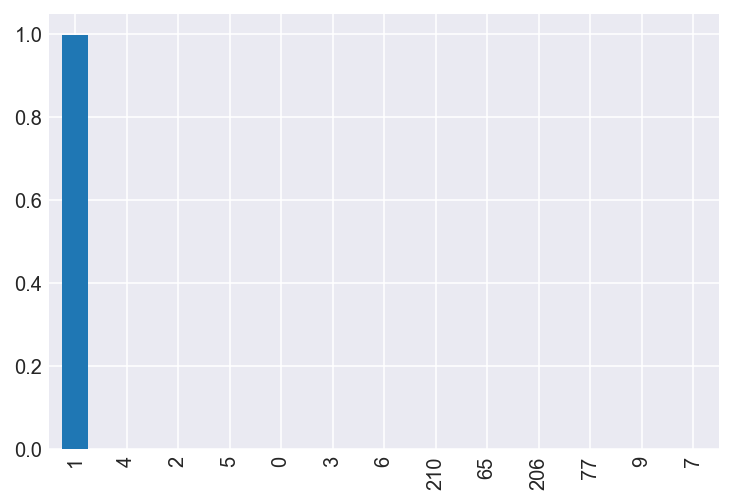

In [8]:
df.rate_code.sort_index(ascending=True).value_counts(normalize=True).plot(kind='bar')
None

In [9]:
# Let's filter down to Rate codes 1, 2 and 3 - NYC and its surrounding airports.
taxidf = df.copy()
taxidf = taxidf[taxidf.rate_code < 4]

In [10]:
taxidf.fare_amount.min()

2.5

In [11]:
taxidf.fare_amount.max()

204.0

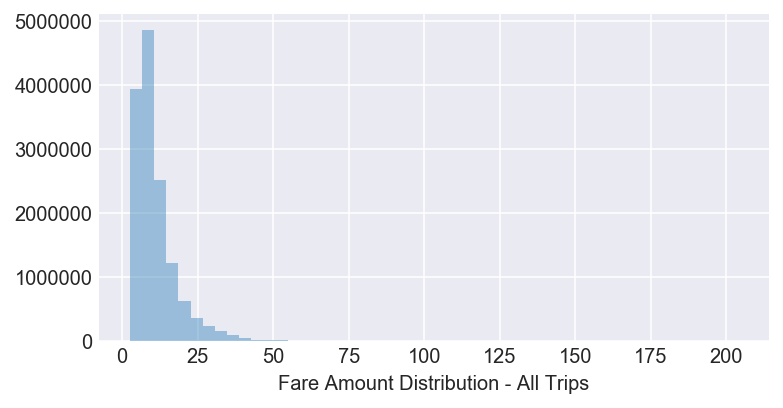

In [12]:
# What does the distribution of fare amounts look like?
fig, ax = plt.subplots(figsize=(6,3))
ax = sns.distplot(taxidf.fare_amount, kde=False)
ax.set_xlabel('Fare Amount Distribution - All Trips')
None

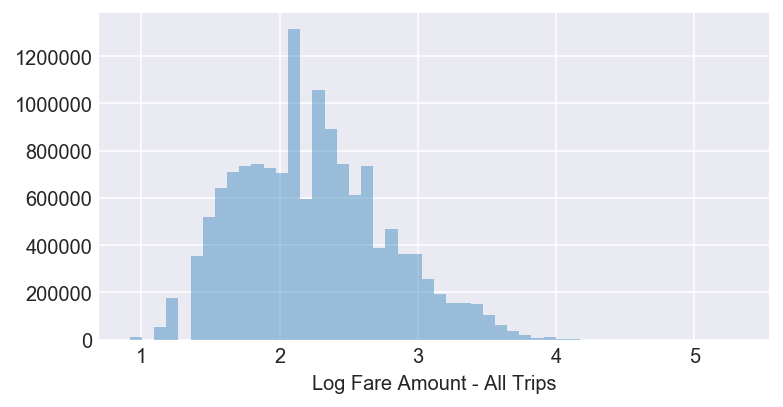

In [13]:
# Taking logs we appear to have a graph which looks slightly normal
fig, ax = plt.subplots(figsize=(6,3))
ax = sns.distplot(np.log(taxidf.fare_amount), kde=False)
ax.set_xlabel('Log Fare Amount - All Trips')
None

## Feature Engineering
---

In [14]:
# Let's codify time of day and day of week
taxidf.pickup_datetime = pd.to_datetime(taxidf.pickup_datetime)
taxidf['pickup_hour'] = taxidf.pickup_datetime.dt.hour
taxidf.dropoff_datetime = pd.to_datetime(taxidf.dropoff_datetime)
taxidf['dropoff_hour'] = taxidf.dropoff_datetime.dt.hour
# 0 = Monday and 6 = Sunday
taxidf['dayofweek'] = taxidf.pickup_datetime.dt.dayofweek
# Day of Month
taxidf['dayofmonth'] = taxidf.pickup_datetime.dt.day
taxidf.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dropoff_hour,dayofweek,dayofmonth
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,0,0,0,1
1,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0,0,0,0,1
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1,0,0,0,1
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711,CRD,7.5,0.5,0.5,2.0,0.0,10.5,0,0,0,1
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556,CRD,7.0,0.5,0.5,1.5,0.0,9.5,0,0,0,1


In [15]:
# Calculate the average taxi speed per hour
taxidf2 = taxidf.groupby(['medallion','dayofmonth','pickup_hour'])\
                .agg({'trip_distance':sum})\
                .rename(columns={'trip_distance':'avgspd_in_hour'}).reset_index()
taxidf = taxidf.merge(taxidf2, on=['medallion','dayofmonth','pickup_hour'])
taxidf.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dropoff_hour,dayofweek,dayofmonth,avgspd_in_hour
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:00:00,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,0,0,0,1,7.00
1,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:24:49,2013-04-01 00:26:17,2,88,0.30,-73.971230,40.757462,-73.975060,40.751656,CSH,3.5,0.5,0.5,0.0,0.0,4.5,0,0,0,1,7.00
2,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:50:29,2013-04-01 01:03:17,1,767,3.30,-73.990074,40.756126,-73.985527,40.726139,CRD,13.0,0.5,0.5,2.8,0.0,16.8,0,1,0,1,7.00
3,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01 00:00:00,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0,0,0,0,1,10.29
4,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01 00:00:00,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1,0,0,0,1,0.97


In [16]:
taxidf3 = taxidf.groupby(['medallion','dayofmonth','pickup_hour'])\
                        .agg({'rate_code':len})\
                        .rename(columns={'rate_code':'trips_per_hour'}).reset_index()
taxidf = taxidf.merge(taxidf3, on=['medallion','dayofmonth','pickup_hour'])
taxidf.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dropoff_hour,dayofweek,dayofmonth,avgspd_in_hour,trips_per_hour
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:00:00,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,0,0,0,1,7.00,3
1,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:24:49,2013-04-01 00:26:17,2,88,0.30,-73.971230,40.757462,-73.975060,40.751656,CSH,3.5,0.5,0.5,0.0,0.0,4.5,0,0,0,1,7.00,3
2,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:50:29,2013-04-01 01:03:17,1,767,3.30,-73.990074,40.756126,-73.985527,40.726139,CRD,13.0,0.5,0.5,2.8,0.0,16.8,0,1,0,1,7.00,3
3,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01 00:00:00,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0,0,0,0,1,10.29,1
4,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01 00:00:00,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1,0,0,0,1,0.97,1


In [17]:
taxidf.avgspd_in_hour.min()

0.01

In [18]:
# This is ridiculous
taxidf.avgspd_in_hour.max()

893.30000000000041

In [19]:
# Let's limit this to all trips where the average hourly speed was under $200mph
taxidf = taxidf[taxidf.avgspd_in_hour < 200.0]
taxidf.avgspd_in_hour.max()

180.40000000000001

## Linear Models
---
Use correlation matrix to identify pertinent features

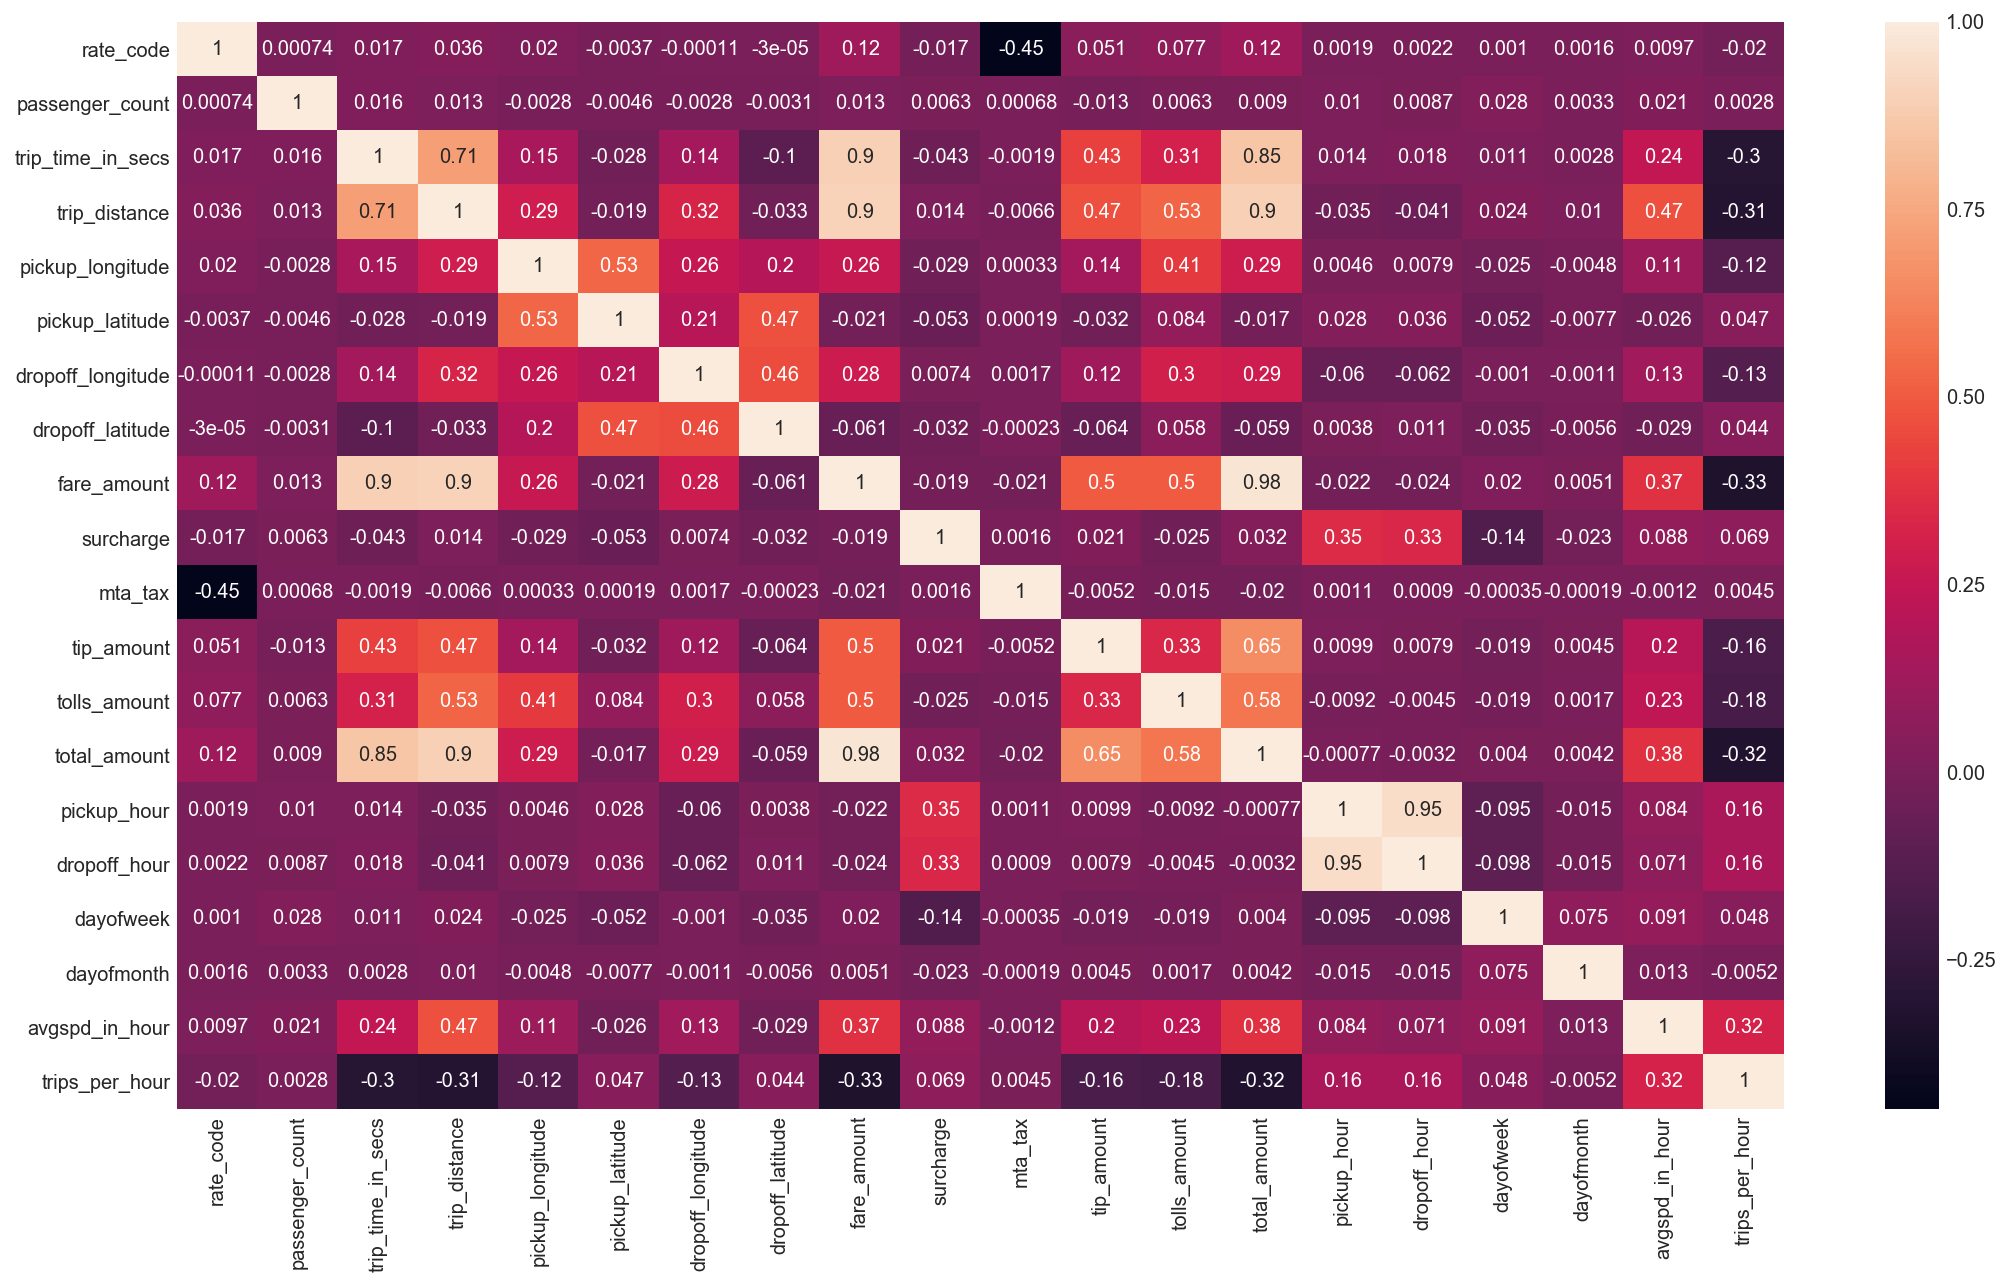

In [20]:
taxidf_corrmat = taxidf.corr()
fig, ax = plt.subplots(figsize=(18,10))
ax = sns.heatmap(taxidf_corrmat, annot = True)
None

Fare Amount is correlated to: 
* trip time in secs 
* distance 
* avg speed per hour
* pickup longitude
* dropoff longitude

### Baseline model
---
The dummy regressor here uses the average of the selected features to predict the value of fare amount

In [21]:
features = taxidf[['avgspd_in_hour','trips_per_hour','pickup_longitude','pickup_latitude',
                      'dropoff_longitude','dropoff_latitude','trip_distance','pickup_hour',
                      'dropoff_hour','dayofweek','dayofmonth']]
target = taxidf.fare_amount
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor

(X_train, X_test, y_train, y_test) = train_test_split(features, target)

dummy = DummyRegressor()
dummy.fit(X_train, y_train)
dummy.score(X_test, y_test)

-5.9227582838161652e-08

## OLS, Huber and RANSAC regression models
---

In [22]:
# Basic Linear Model
features = taxidf[['avgspd_in_hour','trips_per_hour','pickup_longitude','pickup_latitude',
                      'dropoff_longitude','dropoff_latitude','trip_distance','pickup_hour',
                      'dropoff_hour','dayofweek','dayofmonth']]
target = taxidf.fare_amount

(X_train, X_test, y_train, y_test) = train_test_split(features, target)

from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor
ols = LinearRegression()
huber = HuberRegressor()
ransac = RANSACRegressor()
ts = TheilSenRegressor()

# Fit on training set
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [23]:
huber.fit(X_train, y_train)

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

In [24]:
ransac.fit(X_train, y_train)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_trials=100, min_samples=None,
        random_state=None, residual_metric=None, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

In [25]:
# Print R_squared
print "The R-squared of the RANSAC model for All Fares is: ", ransac.score(X_test, y_test)
print "The R-squared of the Huber model for All Fares is: ", huber.score(X_test, y_test)
print "The R-squared of the OLS model for All Fares is: ", ols.score(X_test, y_test)

The R-squared of the RANSAC model for All Fares is:  0.80711411826
The R-squared of the Huber model for All Fares is:  0.814307708508
The R-squared of the OLS model for All Fares is:  0.822483494728


In [26]:
# Median Absolute Error and Mean Squared Error
from sklearn.metrics import median_absolute_error, mean_squared_error
print "Using OLS Regression on average our estimate of taxi fare misses by", \
median_absolute_error(ols.predict(X_test), y_test)
print "Using RANSAC Regression on average our estimate of taxi fares misses by", \
median_absolute_error(ransac.predict(X_test), y_test)
print "Using Huber Regression on average our estimate of taxi fares misses by", \
median_absolute_error(huber.predict(X_test), y_test)

Using OLS Regression on average our estimate of taxi fare misses by 1.13831253506
Using RANSAC Regression on average our estimate of taxi fares misses by 1.01293972465
Using Huber Regression on average our estimate of taxi fares misses by 0.95328389723


In [27]:
print "Using OLS Regression on average our mean squared error is", \
mean_squared_error(ols.predict(X_test), y_test)
print "Using RANSAC Regression on average our mean squared error is", \
mean_squared_error(ransac.predict(X_test), y_test)
print "Using Huber Regression on average our mean squared error is", \
mean_squared_error(huber.predict(X_test), y_test)

Using OLS Regression on average our mean squared error is 7.73272860441
Using RANSAC Regression on average our mean squared error is 8.40222813552
Using Huber Regression on average our mean squared error is 8.08887090154


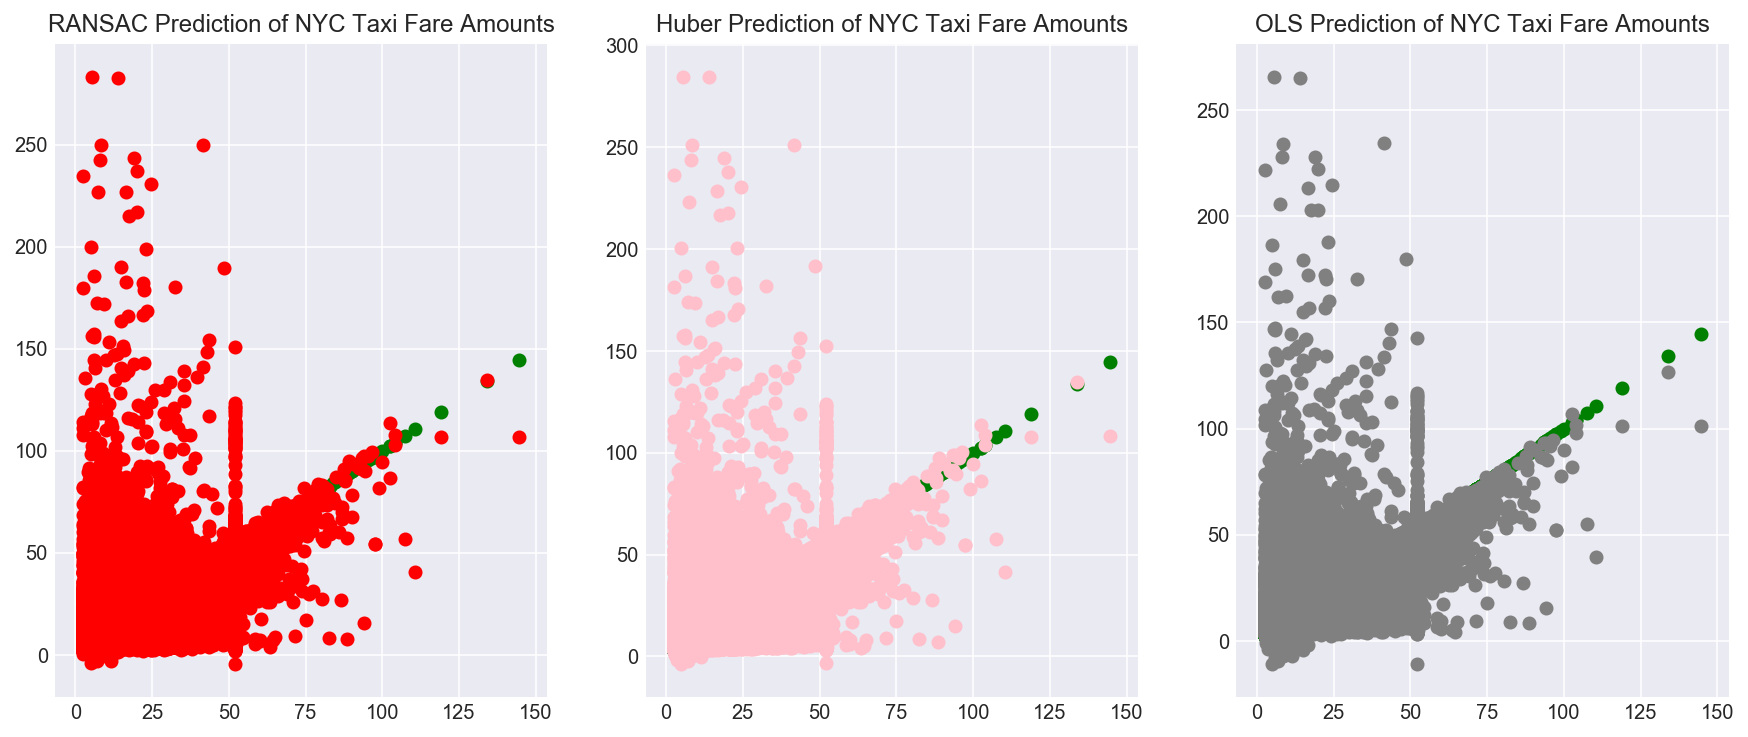

In [28]:
ypred_ols = ols.predict(X_test)
ypred_r = ransac.predict(X_test)
ypred_h = huber.predict(X_test)
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,6))
ax1.scatter(y_test, y_test, c='green')
ax1.scatter(y_test, ypred_r, c='red')
ax1.set_title('RANSAC Prediction of NYC Taxi Fare Amounts')
ax2.scatter(y_test, y_test, c='green')
ax2.scatter(y_test, ypred_h, c='pink')
ax2.set_title('Huber Prediction of NYC Taxi Fare Amounts')
ax3.scatter(y_test, y_test, c='green')
ax3.scatter(y_test, ypred_ols, c='gray')
ax3.set_title('OLS Prediction of NYC Taxi Fare Amounts')
None

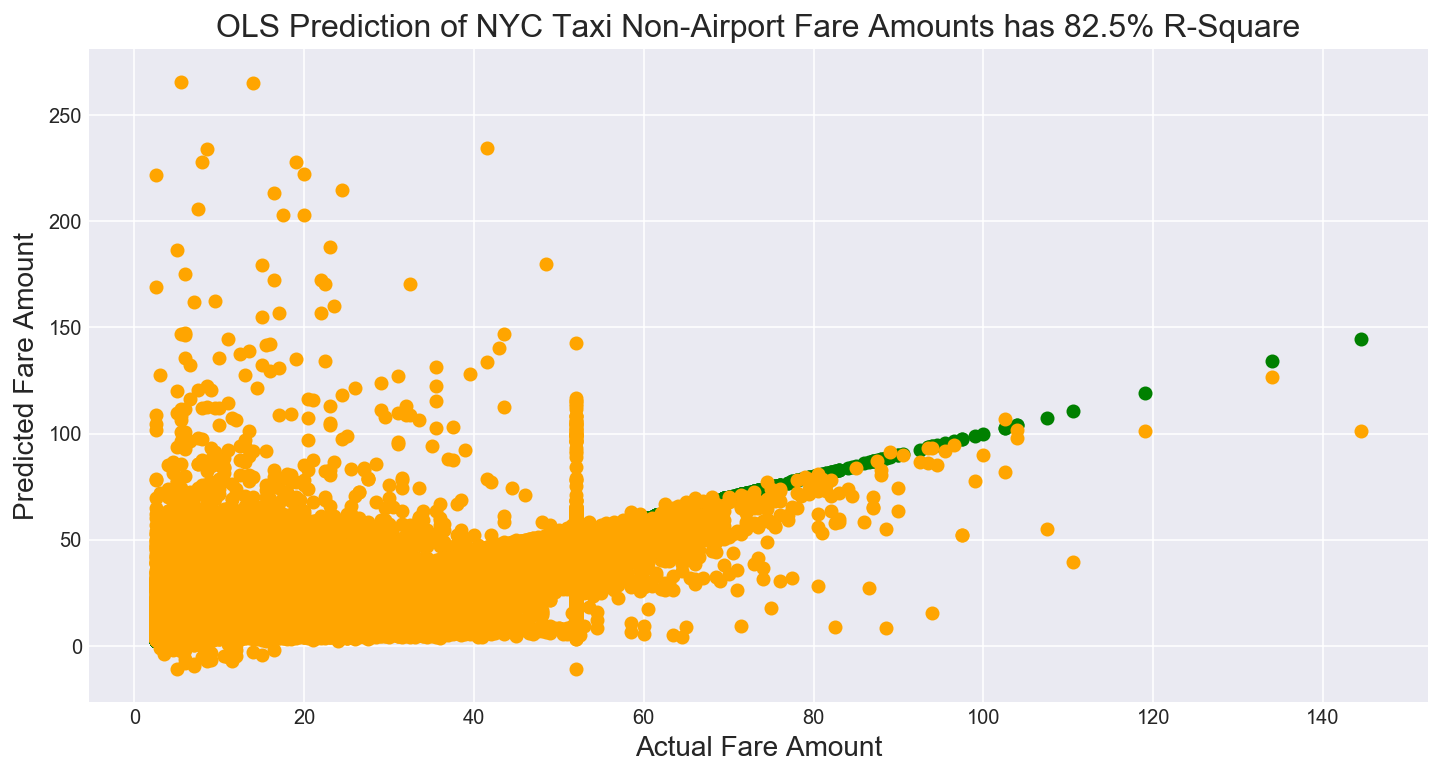

In [29]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(y_test, y_test, c='green')
ax.scatter(y_test, ypred_ols, c='orange')
ax.set_title('OLS Prediction of NYC Taxi Non-Airport Fare Amounts has 82.5% R-Square', fontsize=16)
ax.set_ylabel('Predicted Fare Amount', fontsize=14)
ax.set_xlabel('Actual Fare Amount', fontsize=14)
None

In [30]:
import statsmodels.api as sm
y = target
X1 = features
X1 = sm.add_constant(X1)
res1 = sm.OLS(y, X1, missing='drop').fit()
print(res1.summary())

/Users/hyperion/anaconda/envs/ipykernel_py2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                 5.965e+06
Date:                Mon, 04 Dec 2017   Prob (F-statistic):               0.00
Time:                        13:49:33   Log-Likelihood:            -3.4265e+07
No. Observations:            14050975   AIC:                         6.853e+07
Df Residuals:                14050963   BIC:                         6.853e+07
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                47.9065      5.12

## Check 10-Fold Cross Validation
---
R-square is still 82%

In [31]:
ols = LinearRegression()
y = taxidf.fare_amount
X = taxidf[['avgspd_in_hour','trips_per_hour','pickup_longitude','pickup_latitude',
                      'dropoff_longitude','dropoff_latitude','trip_distance','pickup_hour',
                      'dropoff_hour','dayofweek','dayofmonth']]

sklearn.model_selection.cross_val_score(ols, X, y, cv=10).mean()

0.8219182212926468

## Airport Fares
---

In [32]:
airportdf = taxidf.copy()
nonairportdf = taxidf.copy()
airportdf = airportdf[airportdf.rate_code <> 1]
nonairportdf = nonairportdf[nonairportdf.rate_code == 1]

In [33]:
airportdf.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,pickup_hour,dropoff_hour,dayofweek,dayofmonth,avgspd_in_hour,trips_per_hour
204,297EE2907213112ABA14732D3781808C,CCF62CE81226C96A028907DBBF36720D,CMT,2,2013-04-01 00:00:13,2013-04-01 00:00:36,1,22,7.50,-74.006439,40.718166,-74.006485,40.718143,CRD,52.0,0.0,0.5,10.5,0.00,63.00,0,0,0,1,10.60,2
208,81C4DF9BA06C93EDCC87F6702E0B22F5,51FA34275A96BB8C216F2CBA8A18D0C9,CMT,2,2013-04-01 00:00:13,2013-04-01 00:07:25,1,431,1.70,-73.988914,40.718857,-74.007393,40.733482,CSH,52.0,0.0,0.5,0.0,0.00,52.50,0,0,0,1,1.70,1
5659,D147E34985C6C53EB978954C12667FDA,EE3B97473E38E69D0216927005CE3172,CMT,2,2013-04-01 00:18:10,2013-04-01 00:27:22,1,552,2.10,-73.987267,40.744686,-73.992851,40.721375,CSH,52.0,0.0,0.5,0.0,0.00,52.50,0,0,0,1,6.90,2
5906,5DFA10705410FA86ECFC6447038BF228,24D86F1D5547AE45D4E5FD79D8949064,VTS,2,2013-04-01 00:20:00,2013-04-01 00:32:00,2,720,8.75,-73.857826,40.736092,-73.997910,40.718147,CSH,52.0,0.0,0.5,0.0,0.00,52.50,0,0,0,1,9.41,2
6146,D932DC772B89F69D30F03FB095424F97,F5AE2E36090433DFE4142AFC19AFD495,CMT,2,2013-04-01 00:21:43,2013-04-01 00:35:24,1,820,12.20,-73.905167,40.768223,-73.958923,40.763676,CRD,52.0,0.0,0.5,3.0,5.33,60.83,0,0,0,1,12.20,1


In [77]:
# Airport Fares
# Basic Linear Model
target = airportdf.fare_amount
features = airportdf[['avgspd_in_hour','trips_per_hour','pickup_longitude','pickup_latitude',
                      'dropoff_longitude','dropoff_latitude','trip_distance','pickup_hour',
                      'dropoff_hour','dayofweek','dayofmonth']]

(X_train, X_test, y_train, y_test) = train_test_split(features, target)

from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor
ols = LinearRegression()
huber = HuberRegressor()
ransac = RANSACRegressor()
ts = TheilSenRegressor()

# Fit on training set
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [78]:
huber.fit(X_train, y_train)

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

In [79]:
ts.fit(X_train, y_train)

TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
         max_subpopulation=10000, n_jobs=1, n_subsamples=None,
         random_state=None, tol=0.001, verbose=False)

In [80]:
# Print R_squared
print "The R-squared of the Theil-Sen model for Airport Fares is: ", ts.score(X_test, y_test)
print "The R-squared of the Huber model for Airport Fares is: ", huber.score(X_test, y_test)
print "The R-squared of the OLS model for Airport Fares is: ", ols.score(X_test, y_test)

The R-squared of the Theil-Sen model for Airport Fares is:  -0.165071570261
The R-squared of the Huber model for Airport Fares is:  -0.165018410757
The R-squared of the OLS model for Airport Fares is:  0.17799078618


In [82]:
# Median Absolute Error and Mean Squared Error
from sklearn.metrics import median_absolute_error, mean_squared_error
print "Using OLS Regression on average our estimate of Airport taxi fares misses by", \
median_absolute_error(ols.predict(X_test), y_test)
print "Using Theil-Sen Regression on average our estimate of Airport taxi fares misses by", \
median_absolute_error(ts.predict(X_test), y_test)
print "Using Huber Regression on average our estimate of Airport taxi fares misses by", \
median_absolute_error(huber.predict(X_test), y_test)

 Using OLS Regression on average our estimate of Airport taxi fares misses by 6.84408951247
Using Theil-Sen Regression on average our estimate of Airport taxi fares misses by 1.82656401684e-05
Using Huber Regression on average our estimate of Airport taxi fares misses by 0.0107263291352


In [84]:
print "Using OLS Regression on average our mean squared error is", \
mean_squared_error(ols.predict(X_test), y_test)
print "Using Theil-Sen Regression on average our mean squared error is", \
mean_squared_error(ts.predict(X_test), y_test)
print "Using Huber Regression on average our mean squared error is", \
mean_squared_error(huber.predict(X_test), y_test)

 Using OLS Regression on average our mean squared error is 191.470785121
Using Theil-Sen Regression on average our mean squared error is 271.380374489
Using Huber Regression on average our mean squared error is 271.367992034


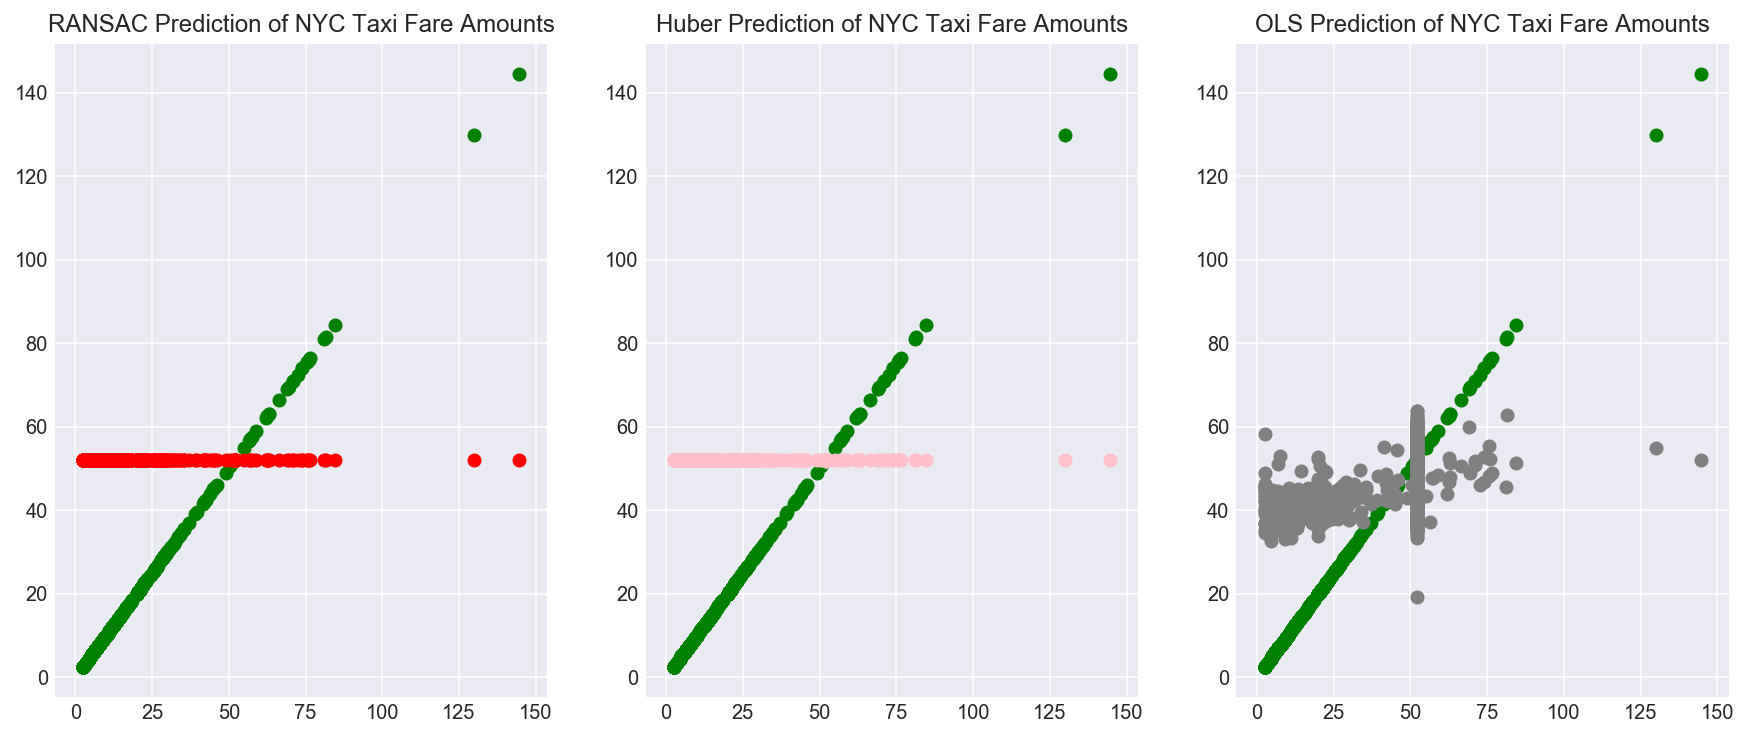

In [38]:
ypred_ols = ols.predict(X_test)
ypred_ts = ts.predict(X_test)
ypred_h = huber.predict(X_test)
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,6))
ax1.scatter(y_test, y_test, c='green')
ax1.scatter(y_test, ypred_ts, c='red')
ax1.set_title('RANSAC Prediction of NYC Taxi Fare Amounts')
ax2.scatter(y_test, y_test, c='green')
ax2.scatter(y_test, ypred_h, c='pink')
ax2.set_title('Huber Prediction of NYC Taxi Fare Amounts')
ax3.scatter(y_test, y_test, c='green')
ax3.scatter(y_test, ypred_ols, c='gray')
ax3.set_title('OLS Prediction of NYC Taxi Fare Amounts')
None

Our linear models do a terrible job at predicting airport fares

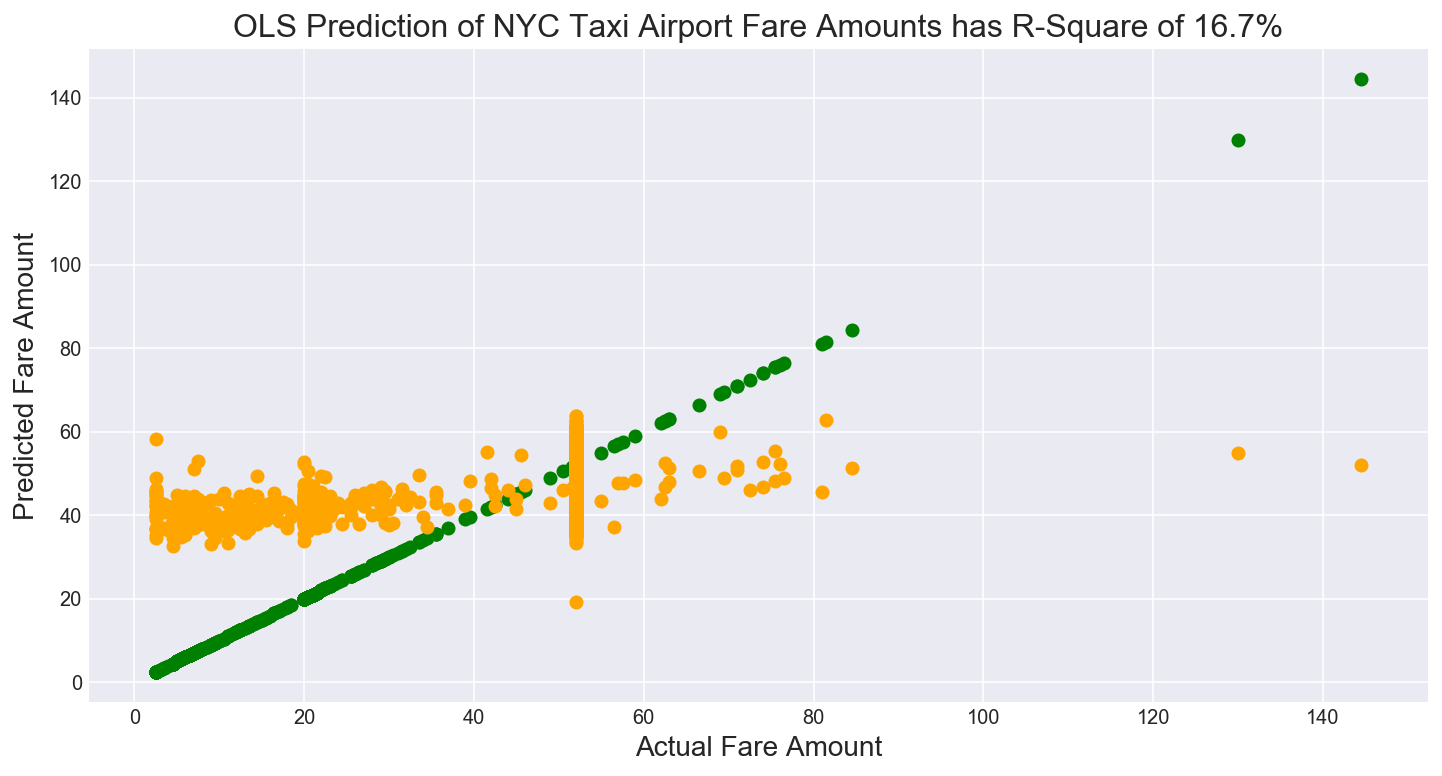

In [39]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(y_test, y_test, c='green')
ax.scatter(y_test, ypred_ols, c='orange')
ax.set_title('OLS Prediction of NYC Taxi Airport Fare Amounts has R-Square of 16.7%', fontsize=16)
ax.set_ylabel('Predicted Fare Amount', fontsize=14)
ax.set_xlabel('Actual Fare Amount', fontsize=14)
None

Wow! Our linear models really miss the mark at predicting airport fares.

## Non-Airport Fares
---

In [40]:
# Basic Linear Model
target = nonairportdf.fare_amount
features = nonairportdf[['avgspd_in_hour','trips_per_hour','pickup_longitude','pickup_latitude',
                      'dropoff_longitude','dropoff_latitude','trip_distance','pickup_hour',
                      'dropoff_hour','dayofweek','dayofmonth']]

(X_train, X_test, y_train, y_test) = train_test_split(features, target)

from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor
ols = LinearRegression()
huber = HuberRegressor()
ransac = RANSACRegressor()
ts = TheilSenRegressor()

# Fit on training set
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [41]:
ransac.fit(X_train, y_train)

RANSACRegressor(base_estimator=None, is_data_valid=None, is_model_valid=None,
        loss='absolute_loss', max_trials=100, min_samples=None,
        random_state=None, residual_metric=None, residual_threshold=None,
        stop_n_inliers=inf, stop_probability=0.99, stop_score=inf)

In [42]:
huber.fit(X_train, y_train)

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

In [44]:
# Print R_squared
print "The R-squared of the RANSAC model for Non-Airport Fares is: ", ransac.score(X_test, y_test)
print "The R-squared of the Huber model for Non-Airport Fares is: ", huber.score(X_test, y_test)
print "The R-squared of the OLS model for Non-Airport Fares is: ", ols.score(X_test, y_test)

 The R-squared of the RANSAC model for Non-Airport Fares is:  0.819299025316
The R-squared of the Huber model for Non-Airport Fares is:  0.828420094087
The R-squared of the OLS model for Non-Airport Fares is:  0.836027785645


In [45]:
# Median Absolute Error and Mean Squared Error
from sklearn.metrics import median_absolute_error, mean_squared_error
print "Using OLS Regression on average our estimate of taxi fare misses by", \
median_absolute_error(ols.predict(X_test), y_test)
print "Using RANSAC Regression on average our estimate of taxi fares misses by", \
median_absolute_error(ransac.predict(X_test), y_test)
print "Using Huber Regression on average our estimate of taxi fares misses by", \
median_absolute_error(huber.predict(X_test), y_test)

Using OLS Regression on average our estimate of taxi fare misses by 1.13009723686
Using RANSAC Regression on average our estimate of taxi fares misses by 0.879534935292
Using Huber Regression on average our estimate of taxi fares misses by 0.953311125931


In [46]:
print "Using OLS Regression on average our mean squared error is", \
mean_squared_error(ols.predict(X_test), y_test)
print "Using RANSAC Regression on average our mean squared error is", \
mean_squared_error(ransac.predict(X_test), y_test)
print "Using Huber Regression on average our mean squared error is", \
mean_squared_error(huber.predict(X_test), y_test)

Using OLS Regression on average our mean squared error is 7.00970683821
Using RANSAC Regression on average our mean squared error is 7.72485059679
Using Huber Regression on average our mean squared error is 7.33493076563


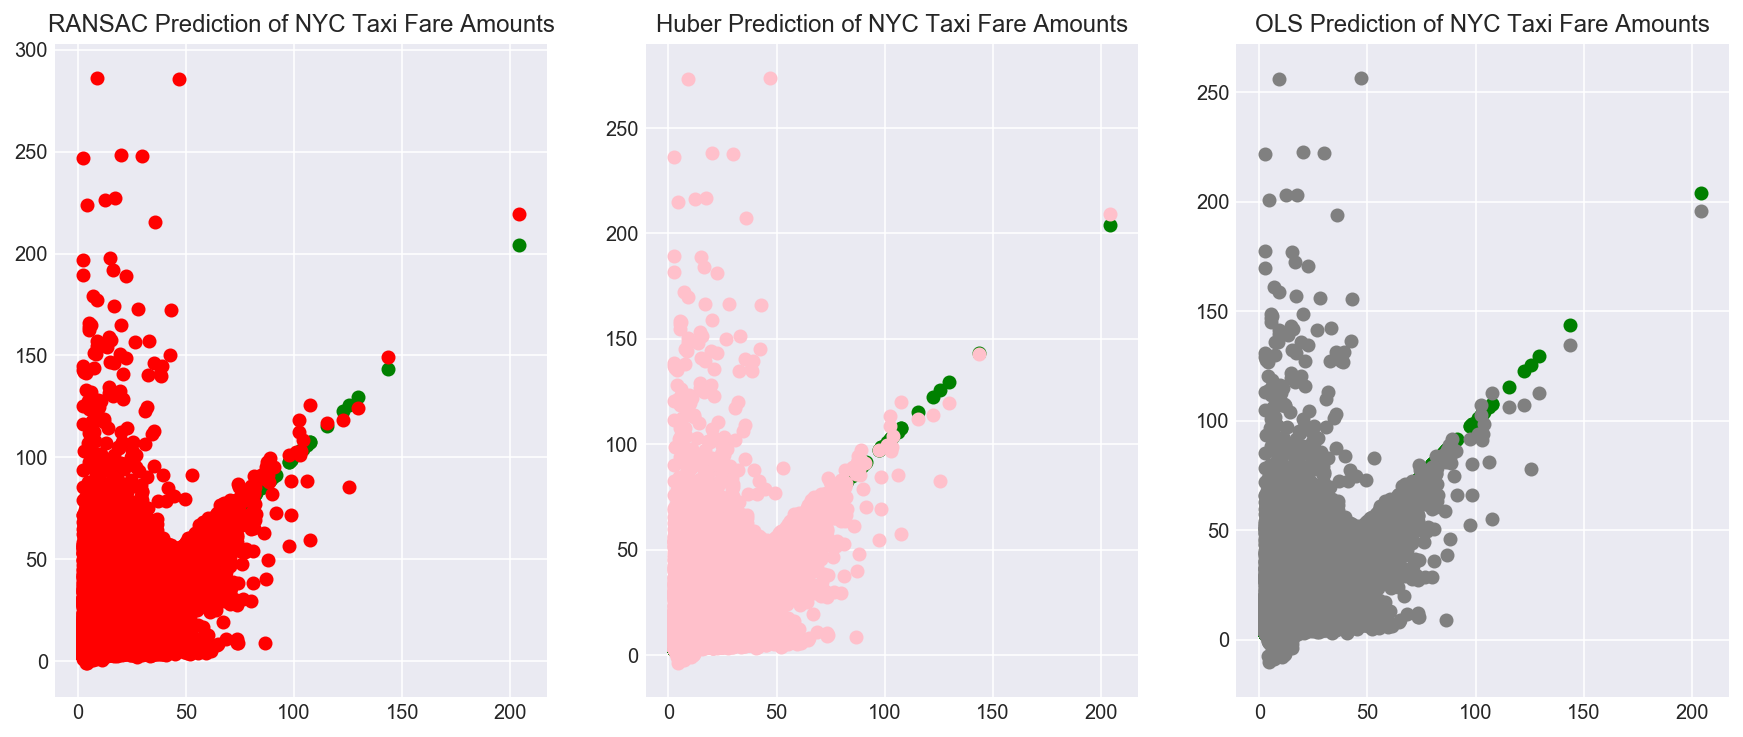

In [48]:
ypred_ols = ols.predict(X_test)
ypred_r = ransac.predict(X_test)
ypred_h = huber.predict(X_test)
f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15,6))
ax1.scatter(y_test, y_test, c='green')
ax1.scatter(y_test, ypred_r, c='red')
ax1.set_title('RANSAC Prediction of NYC Taxi Fare Amounts')
ax2.scatter(y_test, y_test, c='green')
ax2.scatter(y_test, ypred_h, c='pink')
ax2.set_title('Huber Prediction of NYC Taxi Fare Amounts')
ax3.scatter(y_test, y_test, c='green')
ax3.scatter(y_test, ypred_ols, c='gray')
ax3.set_title('OLS Prediction of NYC Taxi Fare Amounts')
None

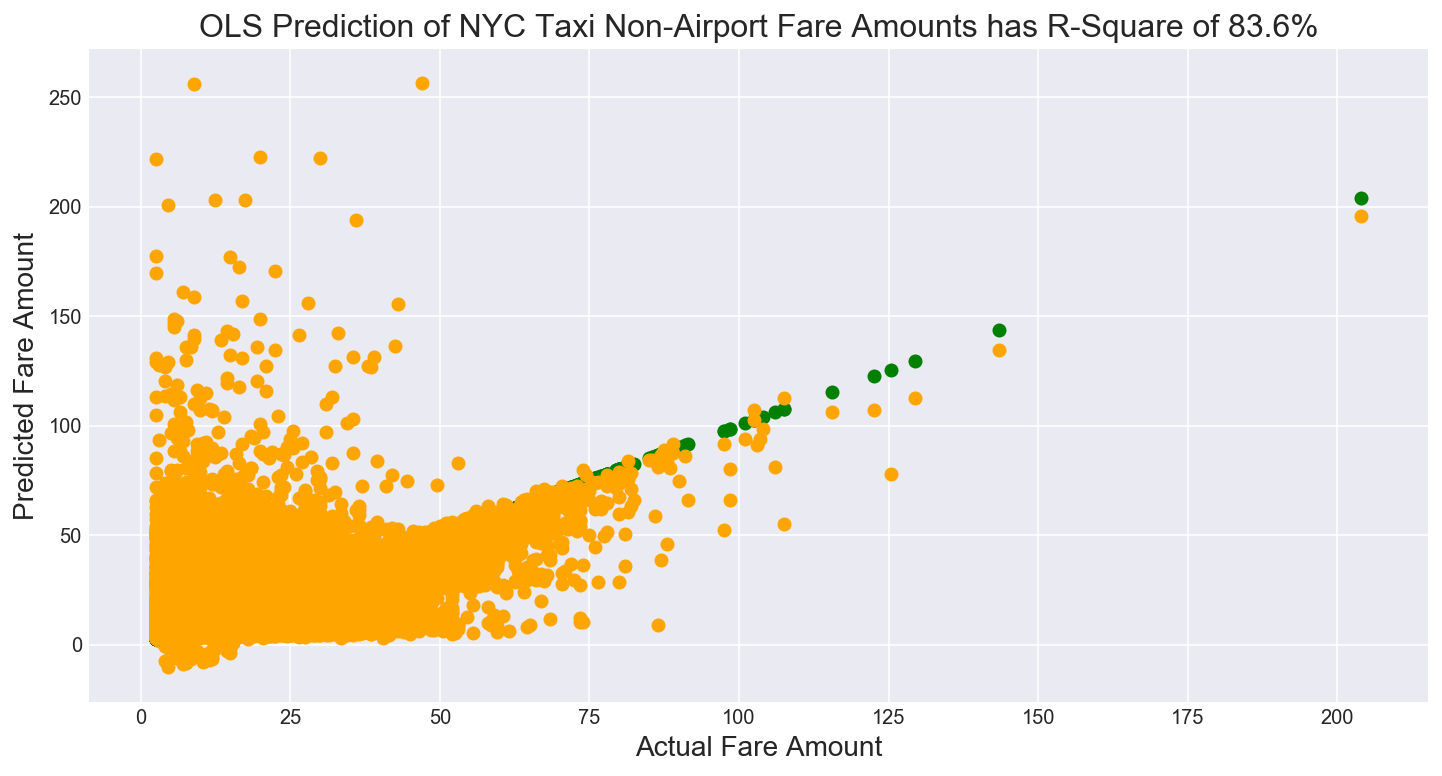

In [49]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(y_test, y_test, c='green')
ax.scatter(y_test, ypred_ols, c='orange')
ax.set_title('OLS Prediction of NYC Taxi Non-Airport Fare Amounts has R-Square of 83.6%', fontsize=16)
ax.set_ylabel('Predicted Fare Amount', fontsize=14)
ax.set_xlabel('Actual Fare Amount', fontsize=14)
None

## Using a Neural Network to better predict airport fares
---

In [68]:
import numpy as np
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Baseline OLS Model

In [85]:
target = airportdf.fare_amount
features = airportdf[['avgspd_in_hour','trips_per_hour','pickup_longitude','pickup_latitude',
                      'dropoff_longitude','dropoff_latitude','trip_distance','pickup_hour',
                      'dropoff_hour','dayofweek','dayofmonth']]

(X_train, X_test, y_train, y_test) = train_test_split(features, target)

from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor
ols = LinearRegression()

# Fit on training set
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [86]:
huber.fit(X_train, y_train)

HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)

In [87]:
ts.fit(X_train, y_train)

TheilSenRegressor(copy_X=True, fit_intercept=True, max_iter=300,
         max_subpopulation=10000, n_jobs=1, n_subsamples=None,
         random_state=None, tol=0.001, verbose=False)

In [88]:
print "Using OLS Regression the mean squared error of airport fares is", \
mean_squared_error(ols.predict(X_test), y_test)
print "Using Theil-Sen Regression the mean squared error of airport fares is", \
mean_squared_error(ts.predict(X_test), y_test)
print "Using Huber Regression the mean squared error of airport fares is", \
mean_squared_error(huber.predict(X_test), y_test)

Using OLS Regression the mean squared error of airport fares is 184.390179705
Using Theil-Sen Regression the mean squared error of airport fares is 259.895993051
Using Huber Regression the mean squared error of airport fares is 259.874183301


### Mean Square Error of Neural Network
---

In [89]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score

# split into input (X) and output (Y) variables
X = airportdf[['avgspd_in_hour','trips_per_hour','pickup_longitude','pickup_latitude',
                      'dropoff_longitude','dropoff_latitude','trip_distance','pickup_hour',
                      'dropoff_hour','dayofweek','dayofmonth']]
Y = airportdf.fare_amount

In [90]:
# Create a neural network function to pass it on to the Keras Regressor
def build_neural_network():
    model = Sequential()
    model.add(Dense(10, input_dim=11, kernel_initializer='random_normal',activation='relu'))
    model.add(Dense(1, kernel_initializer='random_normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [91]:
model = KerasRegressor(build_fn=build_neural_network, epochs=300, verbose=0)
results = cross_val_score(estimator=model, X=np.array(X), y=np.array(Y), cv=10)
print("Using a Neural Network the Mean Square Error of airport fares is %.2f (%.2f)" % (results.mean(), results.std()))

Using a Neural Network the Mean Square Error of airport fares is 179.10 (39.76)


** Doing better than all 3 linear regressors but only slightly better than OLS.**